# Executor Data Overhead

In [1]:
from __future__ import annotations

import importlib
import json
import os
import pathlib

import seaborn
import polars
from matplotlib import pyplot as plt

polars.Config.set_tbl_rows(100)

polars.config.Config

In [17]:
def load_tasks(filepath: pathlib.Path) -> polars.DataFrame:
    tasks = []
    with open(filepath) as f:
        for line in f.readlines():
            task_info = json.loads(line)
            execution_info = task_info.pop('execution')
            task_info = {**task_info, **execution_info}
            tasks.append(task_info)

    return polars.DataFrame(tasks)

def get_info_from_log(filepath: pathlib.Path) -> dict:
    with open(filepath) as f:
        for line in f.readlines():
            if "name='synthetic'" in line:
                config = line
                break
        else:
            raise ValueError("Config not found")

    for term in config.split(' '):
        if 'task_data_bytes' in term:
            size = int(term.split('=')[1][:-1])
            break
    else:
        raise ValueError('Size not found')
    
    if "NullTransformerConfig" in config:
        transformer = "Baseline (None)"
    elif "PickleFileTransformerConfig" in config:
        transformer = "File"
    elif "ProxyFileTransformerConfig" in config:
        if "ps_type='file'" in config:
            transformer = "ProxyStore (File)"
        elif "ps_type='redis'" in config:
            transformer = "ProxyStore (Redis)"
    else:
        raise ValueError(config)

    return {'transformer': transformer, 'size': size}
    

def load_data(directory: pathlib.Path) -> polars.DataFrame:
    runs = []

    for tasks_path in directory.glob('**/tasks.json'):
        app, executor, timestamp = str(tasks_path.relative_to(directory).parent).split('/')
        
        tasks = load_tasks(tasks_path)
        start_time = tasks['submit_time'].min()
        end_time = tasks['received_time'].max()

        info = get_info_from_log(tasks_path.parent / 'log.txt')
        task_time = end_time - start_time

        run_info = {
            'app': app,
            'executor': executor,
            'timestamp': timestamp,
            'transformer': info['transformer'],
            'data-size-bytes': info['size'],
            'time': task_time,
        }
        runs.append(run_info)
    
        # run_info = {
        #     'app': app,
        #     'executor': executor,
        #     'timestamp': timestamp,
        #     'type': 'overhead',
        #     'time': app_time - task_time,
        # }
        # runs.append(run_info)
        # run_info = {
        #     'app': app,
        #     'executor': executor,
        #     'timestamp': timestamp,
        #     'type': 'execution',
        #     'time': task_time,
        # }
        # runs.append(run_info)

    return polars.DataFrame(runs)

In [29]:
data = load_data(pathlib.Path('../runs/data/'))
data

app,executor,timestamp,transformer,data-size-bytes,time
str,str,str,str,i64,f64
"""synthetic""","""process-pool""","""2024-05-26-18-31-42""","""Baseline (None)""",10000,0.02528
"""synthetic""","""process-pool""","""2024-05-26-18-32-33""","""File""",10000,0.029089
"""synthetic""","""process-pool""","""2024-05-26-18-33-17""","""ProxyStore (File)""",10000,0.031992
"""synthetic""","""process-pool""","""2024-05-26-18-33-32""","""ProxyStore (File)""",10000000,0.353685
"""synthetic""","""process-pool""","""2024-05-26-18-33-14""","""ProxyStore (File)""",10000,0.02995
"""synthetic""","""process-pool""","""2024-05-26-18-33-48""","""ProxyStore (Redis)""",10000,0.036723
"""synthetic""","""process-pool""","""2024-05-26-18-32-06""","""Baseline (None)""",1000000,0.069497
"""synthetic""","""process-pool""","""2024-05-26-18-33-49""","""ProxyStore (Redis)""",10000,0.035245
"""synthetic""","""process-pool""","""2024-05-26-18-32-53""","""File""",10000000,0.395188


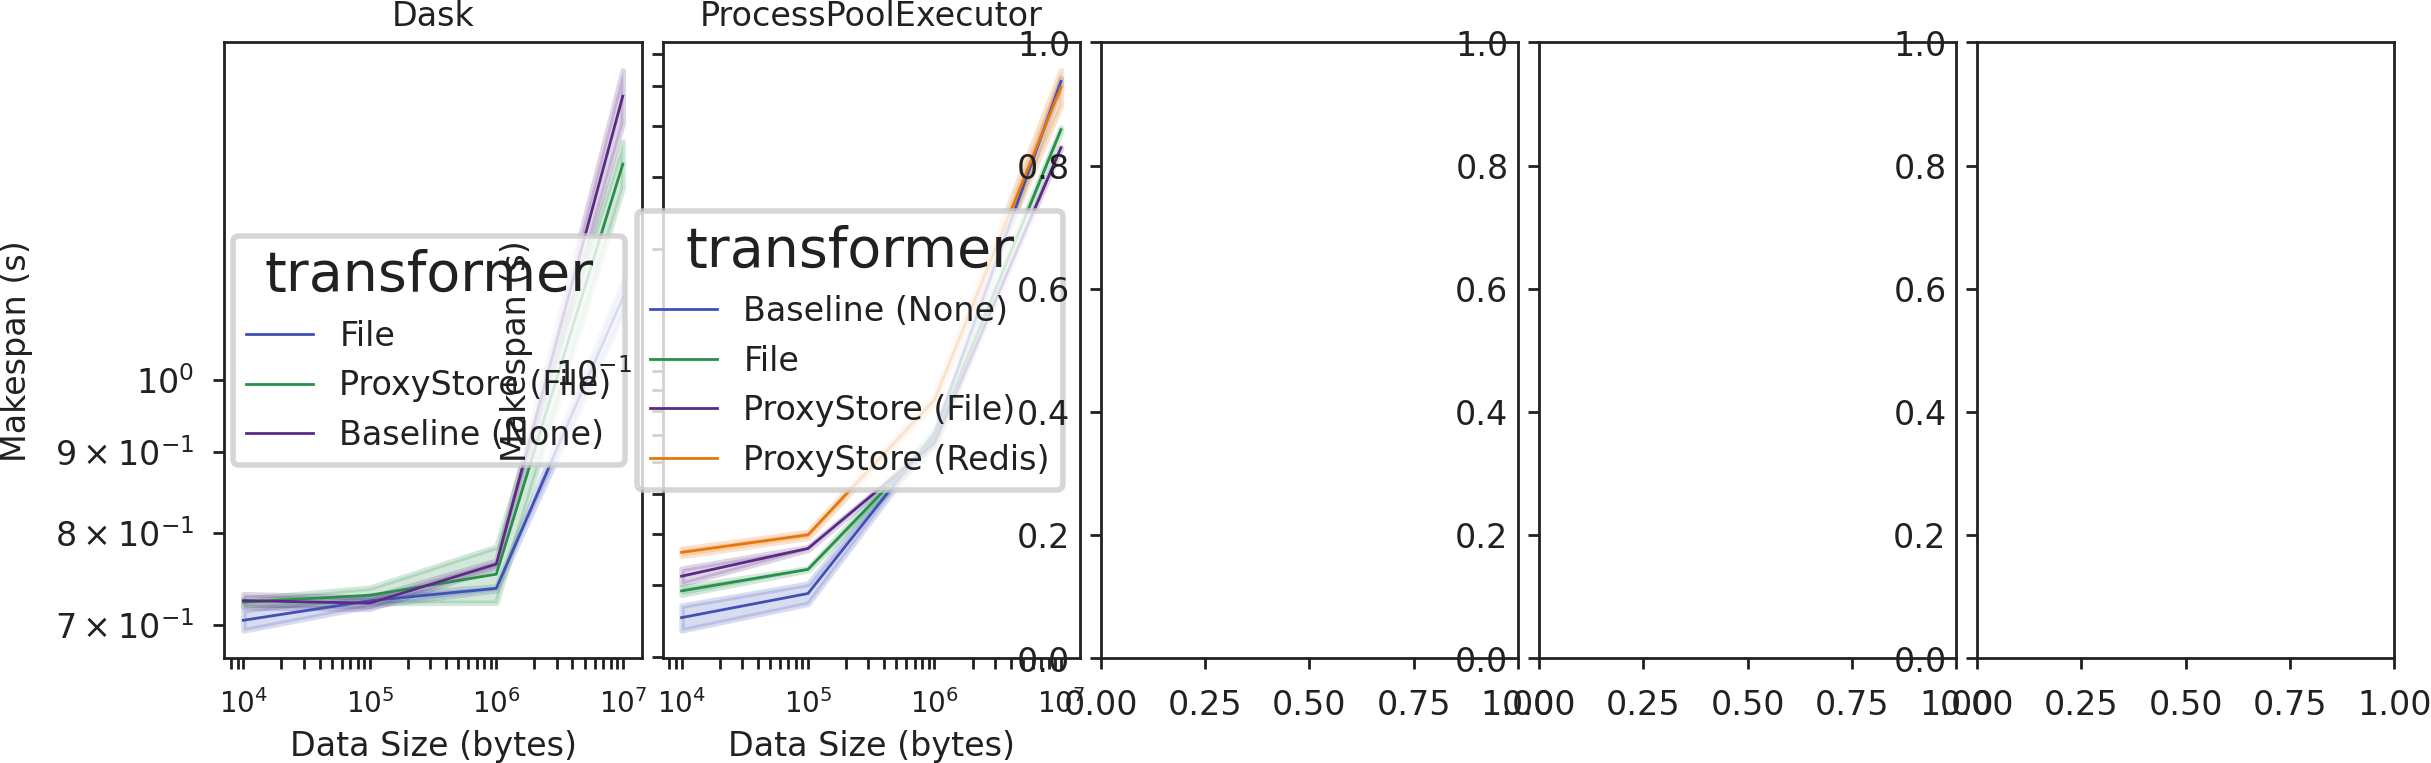

In [30]:
rows, cols = 1, 5
fig, axes = plt.subplots(rows, cols)
executors = sorted(set(data['executor']))
transformers = sorted(set(data['transformer']))
names = {
    'dask': 'Dask',
    'globus-compute': 'Globus Compute',
    'parsl': 'Parsl',
    'process-pool': 'ProcessPoolExecutor',
    'ray': 'Ray',
}
colors = {executor: color['color'] for executor, color in zip(executors, plt.rcParams['axes.prop_cycle'])}
colors = {
    'dask': '#EF1561',
    'globus-compute': '#F89438',
    'parsl': '#2D5D91',
    'process-pool': '#FFDE57',
    'ray': '#028CF0',
}

for x in range(cols):
    if x >= len(executors):
        continue
    executor = executors[x]

    subdata = data.filter(polars.col('executor') == executor)
    ax = axes[x]
    seaborn.lineplot(
        ax=ax,
        data=subdata,
        #order=transformers,
        y='time',
        x='data-size-bytes',
        hue='transformer',
        errorbar='sd',
        # palette=colors,
    )
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_title(names[executor], pad=3)
    ax.set_ylabel('Makespan (s)')
    ax.tick_params(axis='x', labelsize=5)
    if y == rows - 1:
        ax.set_xlabel('Data Size (bytes)', labelpad=2)
    else:
        ax.set_xlabel(None)
    # ax.set_yticks(range(len(executors)))
    # ax.set_yticklabels([names[name] for name in executors])
    # l, r = ax.get_xlim()
    # ax.set_xlim(l * 1.05, r * 1.05)

# TODO: baseline as black dashed line, change colors, use markers with stdev
plt.subplots_adjust(wspace=0.05, hspace=0.5)
fig.set_size_inches(7, 2)
plt.savefig('../figures/data-transformers.pdf', pad_inches=0.05)